In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2001,1,1)
end  = datetime(2020,1,1)
current_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)
pricer_classes.append(Pricer.MONTHLY_STOCK_ROLLING)
pricer_classes.append(Pricer.MONTHLY_STOCK_WINDOW)

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [7]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                ledger= ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 44%|███████████████████████████████████████████████████████                                                                     | 8/18 [00:20<00:26,  2.61s/it]


 44%|███████████████████████████████████████████████████████                                                                     | 8/18 [00:21<00:26,  2.67s/it]


 47%|██████████████████████████████████████████████████████████                                                                 | 17/36 [00:02<00:02,  8.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:46<00:00, 25.12s/it]


In [8]:
trade

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,iteration
0,2001,1,FFIV,1.423265,1.0,0.706608,0,17
1,2001,2,FFIV,2.090631,1.0,0.701299,0,17
2,2001,3,NTAP,2.387940,1.0,1.043478,0,17
3,2001,4,NTAP,2.929974,1.0,1.419660,0,17
4,2001,5,EQIX,3.354809,1.0,1.047244,0,17
...,...,...,...,...,...,...,...,...
4697,2020,8,LVS,0.080852,1.0,1.135376,19,17
4698,2020,9,DVN,0.245530,1.0,0.908046,19,17
4699,2020,10,BXP,0.183030,1.0,1.416192,19,17
4700,2020,11,IFF,0.117083,1.0,0.960045,19,17


In [9]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
45,True,False,False,False,flat,1,tyield1,1,9,dsr_n_n_b_r,13796.278616,-0.144216,0.927010,-95657.374794
46,True,False,False,False,flat,1,tyield2,1,10,dsr_n_n_b_r,13796.278616,-0.144216,0.927010,-95657.374794
47,True,False,False,False,flat,1,tyield10,1,11,dsr_n_n_b_r,13796.278616,-0.144216,0.927010,-95657.374794
53,True,False,False,False,none,1,tyield10,1,17,dsr_n_n_b_r,12991.265602,-0.142269,0.927989,-91307.732762
52,True,False,False,False,none,1,tyield2,1,16,dsr_n_n_b_r,12991.265602,-0.142269,0.927989,-91307.732762
51,True,False,False,False,none,1,tyield1,1,15,dsr_n_n_b_r,12991.265602,-0.142269,0.927989,-91307.732762
29,True,False,False,False,flat,1,tyield10,1,11,wsw_n_n_b_r,11284.614131,-0.492469,0.750648,-22912.350361
28,True,False,False,False,flat,1,tyield2,1,10,wsw_n_n_b_r,11284.614131,-0.492469,0.750648,-22912.350361
27,True,False,False,False,flat,1,tyield1,1,9,wsw_n_n_b_r,11284.614131,-0.492469,0.750648,-22912.350361
33,True,False,False,False,none,1,tyield1,1,15,wsw_n_n_b_r,11274.360864,-0.491885,0.750944,-22918.698748


In [10]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
3,dsr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,9,13796.278616,-0.144216,0.927010,-95657.374794
8,wsw_n_n_b_r,True,False,False,False,flat,1,tyield10,1,11,11284.614131,-0.492469,0.750648,-22912.350361
0,dsb_n_n_b_r,True,True,False,False,rrr,1,tyield10,1,5,8322.176513,-0.123224,0.937641,-67528.900217
7,wsr_n_n_b_r,True,False,False,False,none,1,tyield2,1,16,2447.192773,-0.337138,0.829489,-7255.769830
4,dsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,15,914.390357,-0.090148,0.954403,-10132.123144
6,msw_n_n_b_r,True,False,False,False,none,1,tyield10,1,17,266.434244,0.319017,1.082223,832.030122
5,msr_n_n_b_r,True,False,False,False,none,1,tyield2,1,16,177.014452,0.544685,1.278681,323.144103
1,dsdr_n_n_b_r,True,False,False,False,none,1,tyield2,1,16,58.889123,-0.114833,0.941893,-504.115001
2,dsmr_n_n_b_r,True,True,False,False,flat,1,tyield10,1,2,1.002303,-1.629714,1.275836,-0.001360


In [11]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [12]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [13]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [14]:
positions

20

In [15]:
ledger["position"].max()

19

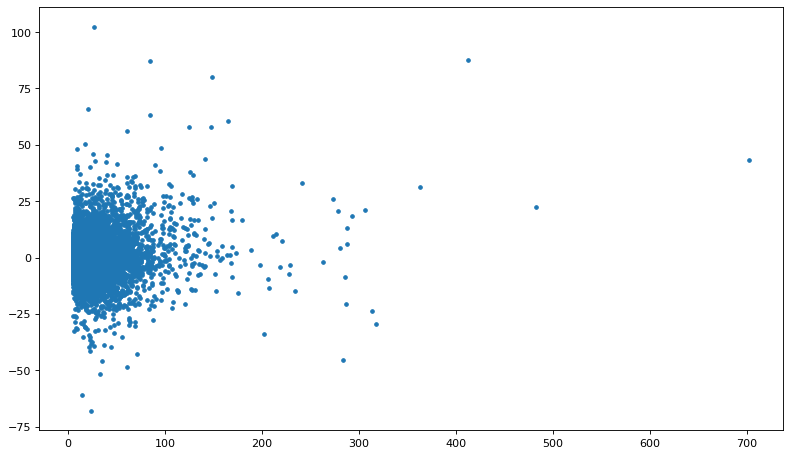

In [16]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [17]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,FFIV,1.050737,1.0,1.268293,0,Information Technology,"F5, Inc."
4713,2001,2001-01-02,AKAM,0.375760,1.0,1.227848,1,Information Technology,Akamai
9367,2001,2001-01-02,DLTR,0.317551,1.0,1.089565,2,Consumer Discretionary,Dollar Tree
13907,2001,2001-01-02,AMZN,0.308194,1.0,1.265130,3,Consumer Discretionary,Amazon
18327,2001,2001-01-02,BKNG,0.306107,1.0,1.283688,4,Consumer Discretionary,Booking Holdings
22592,2001,2001-01-02,ILMN,0.267621,1.0,0.905574,5,Health Care,Illumina
26674,2001,2001-01-02,GLW,0.204920,1.0,1.170114,6,Information Technology,Corning Inc.
30592,2001,2001-01-02,VRSN,0.203505,1.0,1.304158,7,Information Technology,Verisign
34330,2001,2001-01-02,SWKS,0.198324,1.0,1.068034,8,Information Technology,Skyworks Solutions
37898,2001,2001-01-02,NVDA,0.196369,1.0,1.306947,9,Information Technology,Nvidia


In [18]:
ledger.sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
20184,2008,2008-12-04,HIG,0.261279,1.0,2.023578,4,Financials,Hartford (The)
388,2002,2002-07-26,WMB,4.123295,1.0,1.877358,0,Energy,Williams Companies
32235,2008,2008-10-10,MS,0.846386,1.0,1.869835,7,Financials,Morgan Stanley
1951,2008,2008-10-28,LVS,1.485776,1.0,1.800000,0,Consumer Discretionary,Las Vegas Sands
11374,2009,2009-03-13,AIG,0.207317,1.0,1.660000,2,Financials,American International Group
5099,2002,2002-07-24,CNP,0.846646,1.0,1.629630,1,Utilities,CenterPoint Energy
6719,2009,2009-02-05,FITB,1.650000,1.0,1.603659,1,Financials,Fifth Third Bank
15803,2008,2008-11-21,C,1.247784,1.0,1.578249,3,Financials,Citigroup
1954,2008,2008-10-31,HIG,1.469802,1.0,1.577519,0,Financials,Hartford (The)
66,2001,2001-04-06,EQIX,0.605825,1.0,1.559322,0,Real Estate,Equinix


In [19]:
ledger["actual_returns"].mean()

1.0016065578323692

In [20]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5109381818181818

In [21]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [22]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2001-01-02,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,...,0.816667,1.240168,0.969932,1.105118,1.016854,1.026103,1.077517,1.084913,1.102061,1.130042
1,2001,2001-01-03,1.134615,0.861031,0.953728,0.882688,1.000000,0.877893,0.921757,0.927684,...,0.996573,1.023172,1.115001,0.949242,0.939091,1.035330,1.071823,0.877551,0.898882,0.967849
2,2001,2001-01-04,0.959070,0.845011,0.792542,1.104972,0.879457,0.938835,1.085455,0.931034,...,0.974524,0.922266,0.916098,0.896390,0.939355,0.895031,0.981447,0.874642,0.958140,0.907821
3,2001,2001-01-05,1.163919,0.985000,0.986600,0.743300,1.022605,0.958333,0.925212,1.026099,...,0.962144,0.924722,1.031998,1.026212,1.007035,1.016729,0.962330,1.006646,1.032576,1.022611
4,2001,2001-01-08,0.927500,0.971831,0.956140,1.040703,1.103596,0.994115,1.036667,1.021277,...,1.096566,0.916160,0.944162,0.998864,0.941851,1.100413,1.047689,1.005044,1.015869,0.994795
5,2001,2001-01-09,1.217391,0.983111,1.112083,1.076362,1.048073,1.180258,1.040193,1.036996,...,1.034938,1.087926,1.007326,1.066351,0.918490,1.024194,1.052064,1.040323,1.016674,0.985399
6,2001,2001-01-10,1.274286,1.242997,1.032784,0.933333,1.016104,1.015697,1.079566,1.043511,...,1.070872,1.016703,1.107094,1.007222,1.110816,0.993892,0.992908,1.050492,0.945299,1.002741
7,2001,2001-01-11,0.971599,0.970476,1.012394,1.005025,1.047418,1.049521,1.061128,1.083429,...,1.021939,1.064511,1.000000,1.087390,1.048089,0.994380,1.001253,0.973143,0.996139,0.972655
8,2001,2001-01-12,0.938469,1.093058,0.979706,0.999002,1.038462,1.006711,0.989402,1.008723,...,0.978651,0.968559,0.993491,1.029578,1.088608,1.023392,1.005000,0.974368,1.082251,0.991091
9,2001,2001-01-16,0.928056,0.984694,1.115556,0.936039,0.985016,0.907961,0.994296,0.972962,...,0.996690,0.967238,0.968521,0.998464,1.023256,1.012640,1.028103,0.996448,1.002240,1.034322


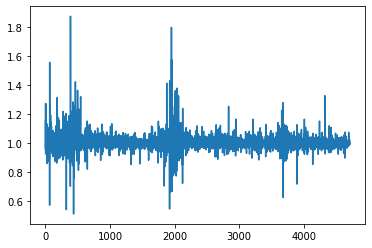

In [23]:
plt.plot(portfolio[0])

In [24]:
positions = ledger["position"].max()

In [25]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [26]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,year,date,week,pv,daily_returns,adjclose,bench
22912,269567.461805,311.043559,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-30,1,14224.758290,1.001207,6665.938,2.908528
22913,269567.461805,311.043559,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-30,1,14224.758290,1.001207,6463.504,2.820200
22914,269567.461805,311.043559,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-30,1,14224.758290,1.001207,6738.855,2.940343
22915,269567.461805,311.043559,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-30,1,14224.758290,1.001207,8945.992,3.903376
22916,269567.461805,311.043559,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-30,1,14224.758290,1.001207,8972.605,3.914988
22917,275225.088470,307.798014,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-31,1,14522.357296,1.000555,6665.938,2.908528
22918,275225.088470,307.798014,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-31,1,14522.357296,1.000555,6463.504,2.820200
22919,275225.088470,307.798014,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-31,1,14522.357296,1.000555,6738.855,2.940343
22920,275225.088470,307.798014,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-31,1,14522.357296,1.000555,8945.992,3.903376
22921,275225.088470,307.798014,3.17562,135.583582,33.403176,91.113463,7.927052,3.416909,14.547133,25.697995,...,5.70926,3.084184,27.903527,2019,2019-12-31,1,14522.357296,1.000555,8972.605,3.914988


In [27]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [28]:
cash_analysis["cash"].sum()

13687.30645352033

In [29]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.122562,NaN,NaN,0.000000,0.000000
1,1.122562,1.0,1.122562,12.256220,12.256220
2,1.122562,1.0,1.122562,12.256220,24.512441
3,1.122562,1.0,1.122562,12.256220,36.768661
4,1.122562,1.0,1.122562,12.256220,49.024881
...,...,...,...,...,...
22917,1.000555,1.0,1.000555,0.055544,13687.084276
22918,1.000555,1.0,1.000555,0.055544,13687.139821
22919,1.000555,1.0,1.000555,0.055544,13687.195365
22920,1.000555,1.0,1.000555,0.055544,13687.250909


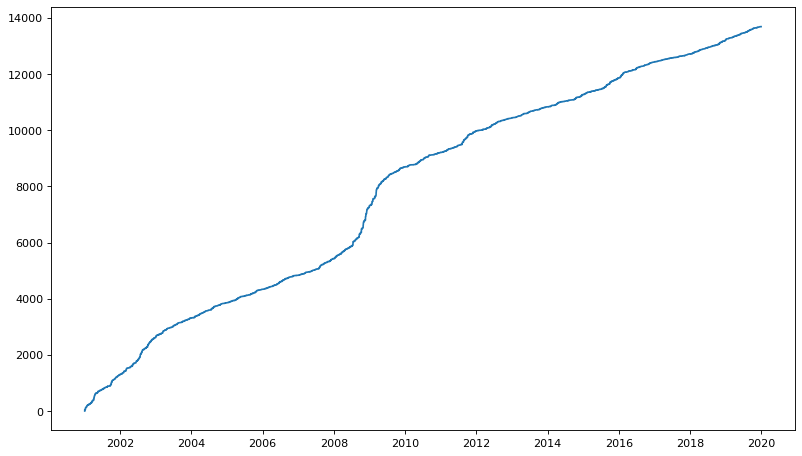

In [30]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

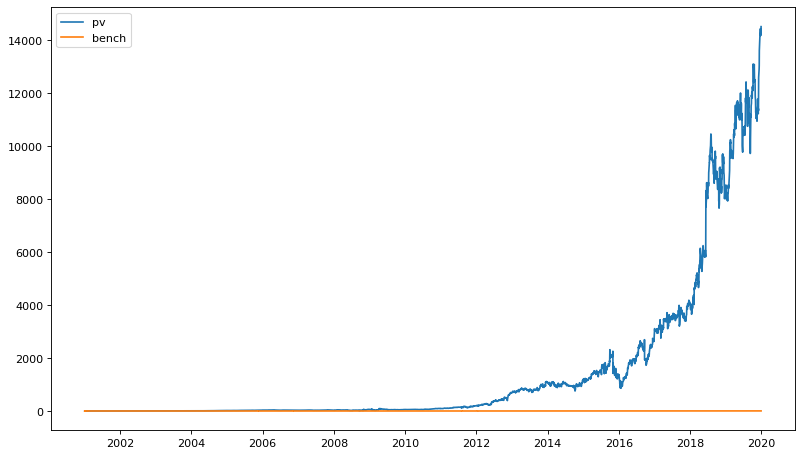

In [31]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [32]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,year,date,week,pv,daily_returns,adjclose,bench
0,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,1.068034,1.306947,...,1.077517,1.084913,1.102061,2001,2001-01-02,1,1.122562,1.122562,2291.86,1.000000
1,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,1.068034,1.306947,...,1.077517,1.084913,1.102061,2001,2001-01-02,1,1.122562,1.122562,2616.69,1.141732
2,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,1.068034,1.306947,...,1.077517,1.084913,1.102061,2001,2001-01-02,1,1.122562,1.122562,2566.83,1.119977
3,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,1.068034,1.306947,...,1.077517,1.084913,1.102061,2001,2001-01-02,1,1.122562,1.122562,2407.65,1.050522
4,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,1.068034,1.306947,...,1.077517,1.084913,1.102061,2001,2001-01-02,1,1.122562,1.122562,1950.40,0.851012
5,1.439024,1.057215,1.039149,1.116715,1.283688,0.794997,1.078561,1.209846,1.082770,1.355549,...,1.154908,0.952066,0.990622,2001,2001-01-03,1,1.093982,0.974581,2291.86,1.000000
6,1.439024,1.057215,1.039149,1.116715,1.283688,0.794997,1.078561,1.209846,1.082770,1.355549,...,1.154908,0.952066,0.990622,2001,2001-01-03,1,1.093982,0.974581,2616.69,1.141732
7,1.439024,1.057215,1.039149,1.116715,1.283688,0.794997,1.078561,1.209846,1.082770,1.355549,...,1.154908,0.952066,0.990622,2001,2001-01-03,1,1.093982,0.974581,2566.83,1.119977
8,1.439024,1.057215,1.039149,1.116715,1.283688,0.794997,1.078561,1.209846,1.082770,1.355549,...,1.154908,0.952066,0.990622,2001,2001-01-03,1,1.093982,0.974581,2407.65,1.050522
9,1.439024,1.057215,1.039149,1.116715,1.283688,0.794997,1.078561,1.209846,1.082770,1.355549,...,1.154908,0.952066,0.990622,2001,2001-01-03,1,1.093982,0.974581,1950.40,0.851012


In [33]:
# plt.figure(figsize=(12, 7), dpi=80)
# position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
# for i in position_columns:
#     position = cumulative[i]
#     plt.plot(cumulative["date"],position)
# plt.show()


In [34]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Financials,2009.317097,0.152950,1.0,1.002454,9.213671
Utilities,2008.205536,0.136802,1.0,1.002364,8.863958
Energy,2011.941989,0.110953,1.0,1.001999,8.928177
Health Care,2008.477487,0.122726,1.0,1.001886,7.607346
Consumer Discretionary,2010.553997,0.115417,1.0,1.001792,8.054455
Information Technology,2008.850923,0.126453,1.0,1.001430,7.836789
Consumer Staples,2010.203157,0.093814,1.0,1.001371,7.825509
Industrials,2010.040383,0.121474,1.0,1.001130,8.467189
Materials,2011.225336,0.109939,1.0,1.001089,8.555333


In [35]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                      
2008 2008-12-04 HIG    Hartford (The)                     0.261279   
2002 2002-07-26 WMB    Williams Companies                 4.123295   
2008 2008-10-10 MS     Morgan Stanley                     0.846386   
     2008-10-28 LVS    Las Vegas Sands                    1.485776   
2009 2009-03-13 AIG    American International Group       0.207317   
2002 2002-07-24 CNP    CenterPoint Energy                 0.846646   
2009 2009-02-05 FITB   Fifth Third Bank                   1.650000   
2008 2008-11-21 C      Citigroup                          1.247784   
     2008-10-31 HIG    Hartford (The)                     1.469802   
2001 2001-04-06 EQIX   Equinix                            0.605825   
2008 2008-12-03 DXCM   Dexcom                             0.168500   
2009 2009-02-05 RF     Regions Financial Corporation      0.957400   
     2009-04-02 MGM    MGM Resorts                        0.093536   
2002 2002-07-25 JCI    Johnson Controls                   0.256100   
     2002-03-06 SBAC   SBA Communications                 0.396374   
2008 2008-11-24 LNC    Lincoln Financial                  1.411164   
     2008-09-18 AIG    American International Group       7.028461   
     2008-11-12 CBRE   CBRE Group                         0.272115   
2002 2002-11-14 ALGN   Align Technology                   0.387692   
2008 2008-07-15 UAL    United Airlines Holdings           0.504227   
2002 2002-07-26 AES    AES Corporation                    0.892373   
2014 2014-06-23 VRTX   Vertex Pharmaceuticals             0.092164   
2008 2008-07-16 HBAN   Huntington National Bank           0.223922   
2002 2002-10-30 AES    AES Corporation                    0.085484   
2008 2008-10-10 PRU    Prudential Financial               0.947460   
2009 2009-03-09 C      Citigroup                          1.251942   
2013 2013-02-13 STZ    Constellation Brands               0.126167   
2008 2008-10-30 LVS    Las Vegas Sands                    0.401852   
2003 2003-01-06 EQIX   Equinix                            0.460433   
2009 2009-01-27 FITB   Fifth Third Bank                   1.284201   

                                                      dately_delta_sign  \
year date       ticker Security                                           
2008 2008-12-04 HIG    Hartford (The)                               1.0   
2002 2002-07-26 WMB    Williams Companies                           1.0   
2008 2008-10-10 MS     Morgan Stanley                               1.0   
     2008-10-28 LVS    Las Vegas Sands                              1.0   
2009 2009-03-13 AIG    American International Group                 1.0   
2002 2002-07-24 CNP    CenterPoint Energy                           1.0   
2009 2009-02-05 FITB   Fifth Third Bank                             1.0   
2008 2008-11-21 C      Citigroup                                    1.0   
     2008-10-31 HIG    Hartford (The)                               1.0   
2001 2001-04-06 EQIX   Equinix                                      1.0   
2008 2008-12-03 DXCM   Dexcom                                       1.0   
2009 2009-02-05 RF     Regions Financial Corporation                1.0   
     2009-04-02 MGM    MGM Resorts                                  1.0   
2002 2002-07-25 JCI    Johnson Controls                             1.0   
     2002-03-06 SBAC   SBA Communications                           1.0   
2008 2008-11-24 LNC    Lincoln Financial                            1.0   
     2008-09-18 AIG    American International Group                 1.0   
     2008-11-12 CBRE   CBRE Group                                   1.0   
2002 2002-11-14 ALGN   Align Technology                             1.0   
2008 2008-07-15 UAL    United Airlines Holdings                     1.0   
2002 2002-07-26 AES    AES Corporation                              1.0   
2014 2014-06-23 VRTX   Vertex Pharmaceuticals                       1.0   
2008 2008-07-

In [36]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-02 00:00:00.000000000,1.000000,1.152079,1.000000,1.000000,1.000000,0.905574,1.084913,1.168867,1.00000,1.016854,0.816667
1,4004001,2252-06-29 23:17:13.297436672,1.000000,1.074684,1.000000,1.000000,1.000000,0.926557,1.050032,1.157669,1.00000,1.016854,0.716667
2,8012006001,2159-09-27 04:21:44.589074432,1.000000,1.074445,1.000000,1.000000,0.907821,0.837437,1.050032,1.035556,1.00000,1.123596,0.695352
3,16032024008001,1970-01-01 00:00:00.000000000,1.000000,1.081267,1.000000,1.000000,0.923008,0.773215,1.050032,1.001380,1.00000,1.106742,0.730312
4,32080080040010001,1970-01-01 00:00:00.000000000,1.000000,1.101939,1.000000,1.000000,0.918203,0.788000,1.050032,1.018021,1.00000,1.044944,0.677364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,0,1970-01-01 00:00:00.000000000,5.558625,797.950597,5.269394,13.524943,5.004404,9.989676,10.315155,516.743218,4.83440,0.618826,2.294178
4709,0,1970-01-01 00:00:00.000000000,5.558625,791.830327,5.269394,13.524943,5.004404,9.888033,10.315155,521.892391,4.87498,0.618826,2.294178
4710,0,1970-01-01 00:00:00.000000000,5.558625,790.968274,5.269394,13.524943,5.004404,9.772370,10.315155,522.695808,4.87498,0.618826,2.294178
4711,0,1970-01-01 00:00:00.000000000,5.558625,792.235380,5.269394,13.524943,5.004404,9.965142,10.315155,522.695808,4.87498,0.618826,2.294178
